# Game Of Thrones project

### importing libraries and installing packages 

In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [63]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel

### import dataset (taken from kaggle)

In [4]:
char_data = pd.read_csv('character-predictions.csv')
char_data.head(10)

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1
5,6,1,0,0.021,0.979,Tommen Baratheon,NaN,1,NaN,NaN,...,1.0,NaN,0,0,NaN,5,1,1,1.000000,1
6,7,0,0,0.014,0.986,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,...,NaN,1.0,1,1,26.0,0,0,1,0.431438,0
7,8,0,0,0.036,0.964,Viserys I Targaryen,NaN,1,NaN,NaN,...,1.0,NaN,0,0,NaN,5,1,1,0.678930,0
8,9,0,1,0.724,0.276,Wilbert,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.006689,0
9,10,1,0,0.391,0.609,Wilbert Osgrey,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.020067,1


In [5]:
# Information about the Variables
char_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

### exploratory data analysis

percentage of dead: 25.437
percentage of alive: 74.563


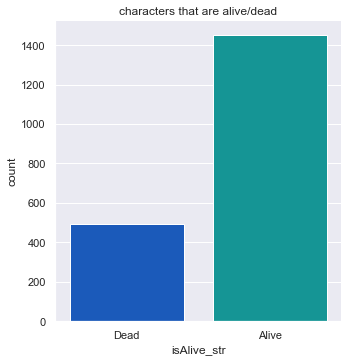

In [33]:
# exploring alive/dead characters 
isAlive_str = {0:"Dead", 1:"Alive"}
char_data["isAlive_str"] = char_data["isAlive"].map(isAlive_str)
sb.catplot(x = "isAlive_str", data = char_data, kind = "count", palette = "winter").set(title='characters that are alive/dead')
print("percentage of dead:", (((char_data['isAlive']==0).sum())*100/1946).round(3))
print("percentage of alive:",  (((char_data['isAlive']==1).sum())*100/1946).round(3))

gender distribution for ALL characters
percentage of male: 61.922
percentage of female: 38.078

gender distribution for DEAD characters
percentage of male: 74.141
percentage of female: 25.859


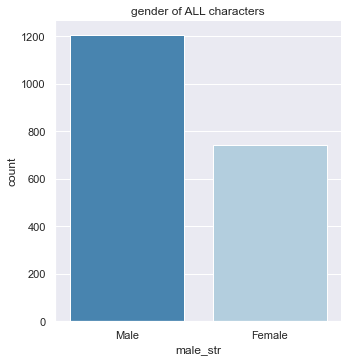

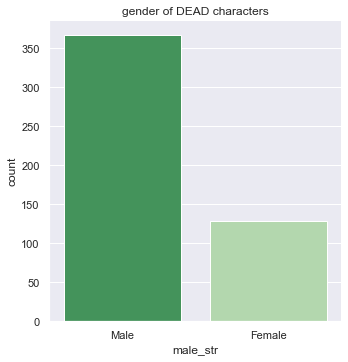

In [44]:
#explore gender of all
male_str = {0:"Female", 1:"Male"}
char_data["male_str"] = char_data["male"].map(male_str)
sb.catplot(x = "male_str", data = char_data, kind = "count", palette = "Blues_r").set(title='gender of ALL characters')
print("gender distribution for ALL characters")
print("percentage of male:", (((char_data['male_str']=="Male").sum())*100/1946).round(3))
print("percentage of female:",  (((char_data['male_str']=="Female").sum())*100/1946).round(3))
print()
#explore gender of dead 
char_data_dead = char_data[char_data.isAlive == 0]
sb.catplot(x = "male_str", data = char_data_dead, kind = "count", palette = "Greens_r").set(title='gender of DEAD characters')
print("gender distribution for DEAD characters")
print("percentage of male:", (((char_data_dead['male_str']=="Male").sum())*100/(char_data_dead['male_str']).count()).round(3))
print("percentage of female:",  (((char_data_dead['male_str']=="Female").sum())*100/(char_data_dead['male_str']).count()).round(3))

In [8]:
#exploring houses of dead/alive
char_data['house']=char_data['house'].fillna('unKnown')
char_data['houseAlive'] = char_data_alive['house'].map(char_data_alive['house'].value_counts())
char_data['houseDead'] = char_data_dead['house'].map(char_data_dead['house'].value_counts())

#as there are many houses, we take the 10 most popular houses (that most characters belong to)
housecount = char_data.groupby("house").count().sort_values(by = "name", ascending = False)[:10][['houseDead','houseAlive']].transpose().reset_index()
print(housecount) 


house       index  unKnown  Night's Watch  House Frey  House Stark  \
0       houseDead       95             45          14           22   
1      houseAlive      332             60          83           50   

house  House Targaryen  House Lannister  House Greyjoy  House Tyrell  \
0                   41               18             14             2   
1                   21               31             27            34   

house  House Martell  House Osgrey  
0                  4             5  
1                 25            16  


<AxesSubplot:title={'center':'Houses of dead vs Alive'}, xlabel='index'>

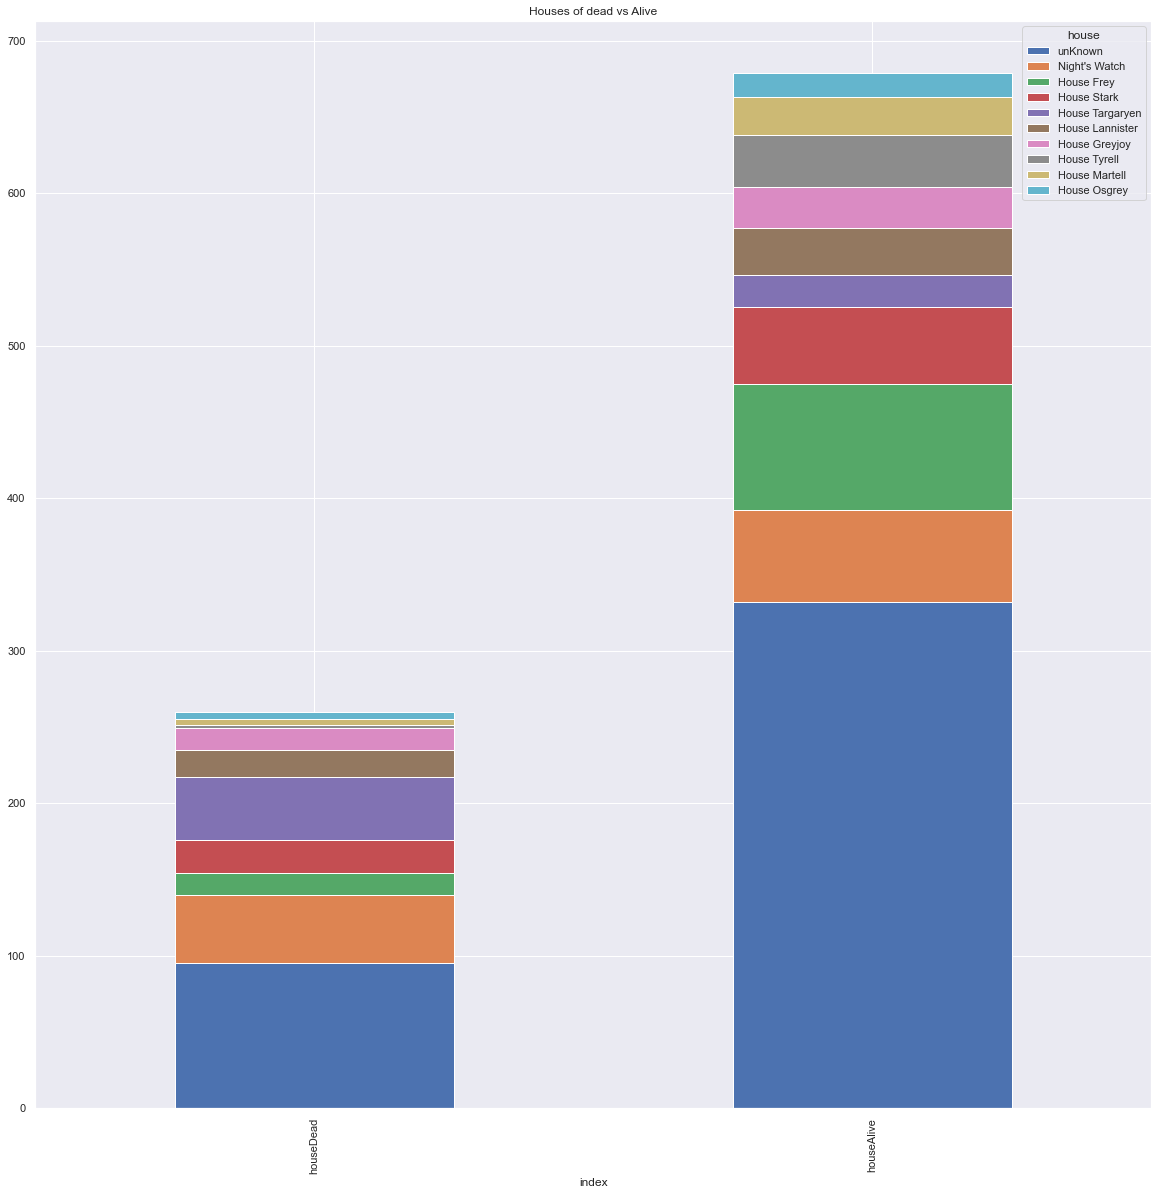

In [9]:
#plot to see houses of dead vs houses of alive 
housecount.plot.bar(x='index', stacked=True, title='Houses of dead vs Alive', figsize=(20,20))

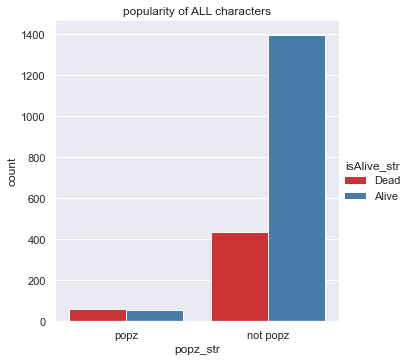

In [10]:
#explore categorical varibale for popularity 
popz_str = {0:"not popz", 1:"popz"}
char_data["popz_str"] = char_data["isPopular"].map(popz_str)
sb.catplot(x = "popz_str", data = char_data, kind = "count", hue="isAlive_str", palette= "Set1").set(title='popularity of ALL characters')

From our bar plot, it seems like majority of the characters are categorized as not popular. Hence, we explore the numerical variable for popularity instead. 

<AxesSubplot:xlabel='popularity', ylabel='isAlive_str'>

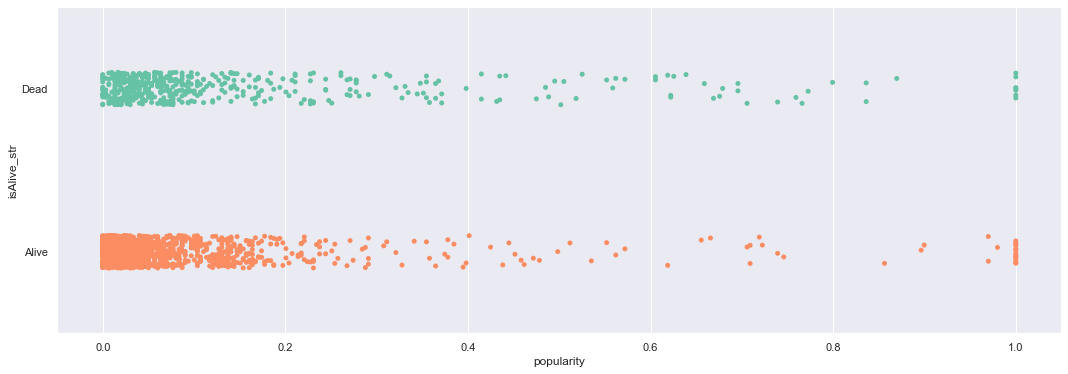

In [11]:
#explore numerical variable for popularity 
f = plt.figure(figsize=(18, 6))
sb.stripplot(x = "popularity", y = "isAlive_str", data = char_data, orient = "h", palette= "Set2")


The strip plots look rather similar. However, we are unable to tell if popularity is a good predictor purely just from the strip plot (for now).

<AxesSubplot:>

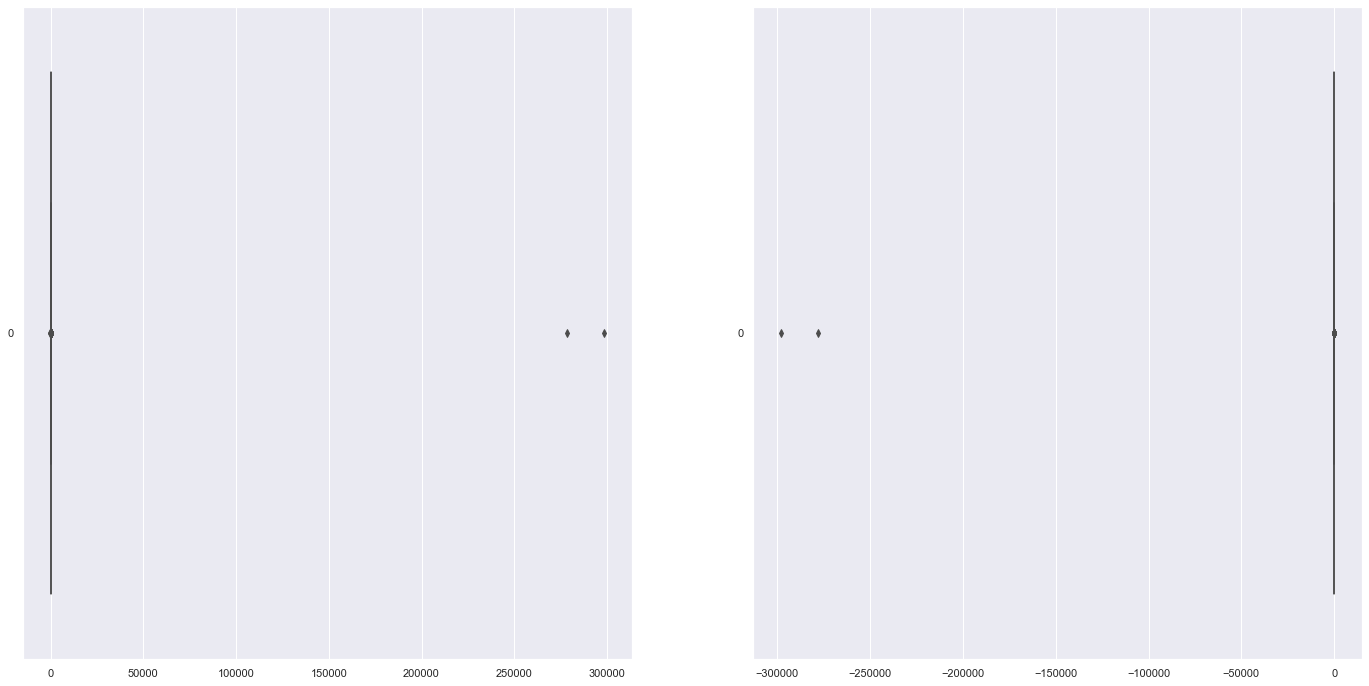

In [14]:
#explore dateofbirth and age

f, axes = plt.subplots(1,2, figsize=(24, 12))
sb.boxplot(data = char_data['dateOfBirth'], orient = "h", ax = axes[0])
sb.boxplot(data = char_data['age'], orient = "h", ax = axes[1])


For both date of birth and age variables, there are 2 distinct outliers as seen from the boxplot. Hence, we should remove these outliers as part of our cleaning process for the dataset.  

In [17]:
#to find the values of the outliers 
print(char_data['dateOfBirth'][char_data['dateOfBirth']>=250000])
print(char_data['age'][char_data['age']<=-250000])

1684    278279.0
1868    298299.0
Name: dateOfBirth, dtype: float64
1684   -277980.0
1868   -298001.0
Name: age, dtype: float64


In [18]:
#cleaning outliers
char_data['age'].values[char_data['age'] == -298001] = 0
char_data['age'].values[char_data['age'] == -277980] = 20
char_data['dateOfBirth'].values[char_data['dateOfBirth'] == 298299] = 298
char_data['dateOfBirth'].values[char_data['dateOfBirth'] == 278279] = 278


<AxesSubplot:ylabel='age'>

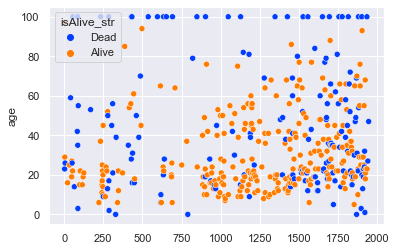

In [27]:
#age scatterplot
sb.scatterplot(x=char_data.index, y = char_data['age'], hue = char_data['isAlive_str'], palette = "bright")

<AxesSubplot:ylabel='dateOfBirth'>

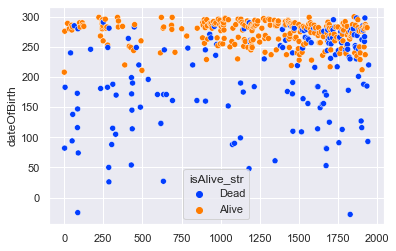

In [28]:
#date of birth scatterplot
sb.scatterplot(x=char_data.index, y = char_data['dateOfBirth'], hue = char_data['isAlive_str'], palette = "bright")

After removing the outliers, it seems that characters with a more recent date of birth, and hence lower age are mostly still alive. 

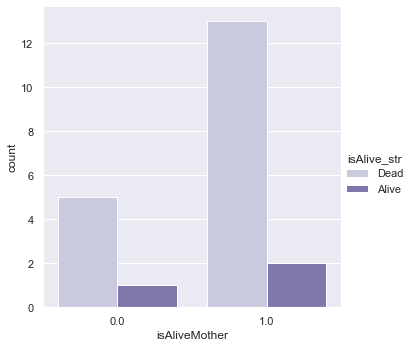

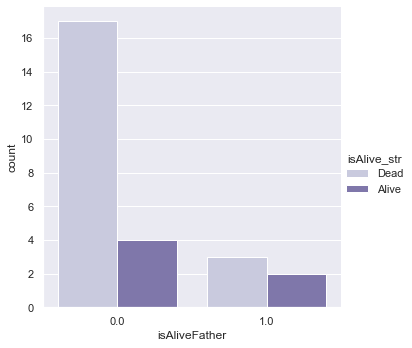

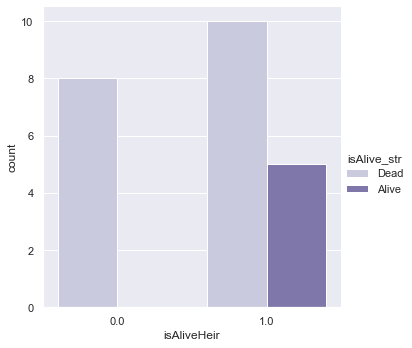

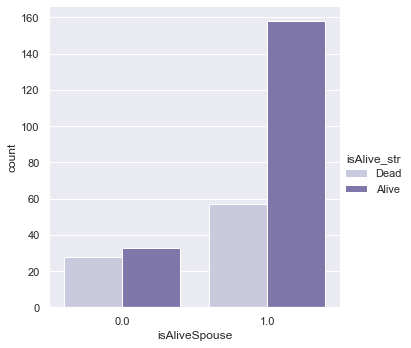

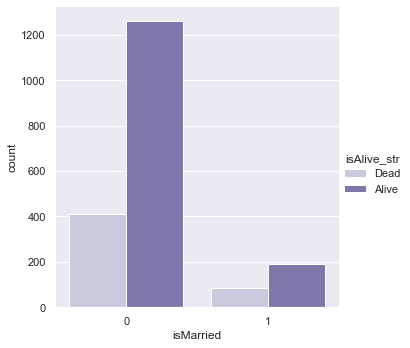

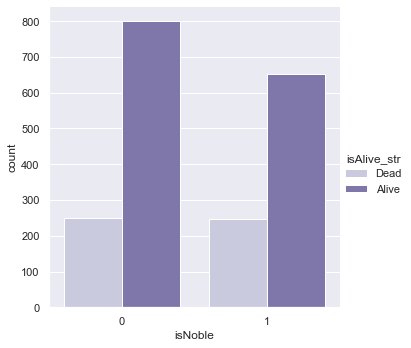

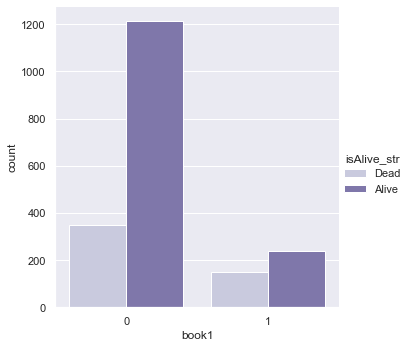

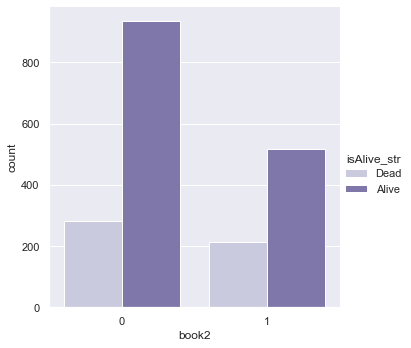

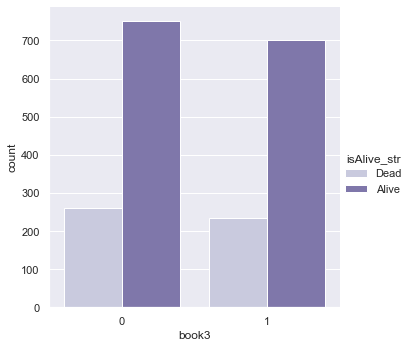

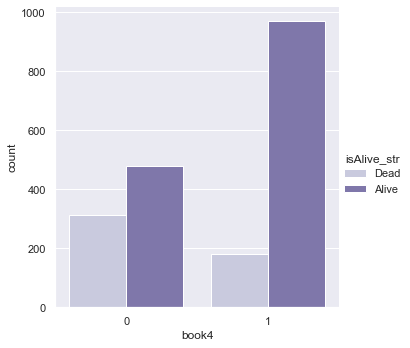

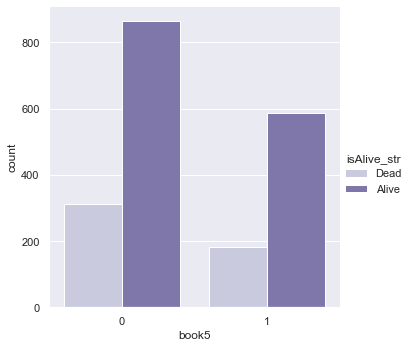

In [49]:
#now we explore other variables 
names=['isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse', 'isMarried', 'isNoble', 'book1', 'book2', 'book3', 'book4', 'book5']
for var in names:
    sb.catplot(x = var, data = char_data, kind = "count", hue="isAlive_str", palette= "Purples")

### cleaning dataset
##### choosing variables for prediction

In [50]:
char_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1946 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

Our first criteria is to select the variables that contain the least number of null values. 
We hence select the variables with zero missing values first. 
We have also selected dateOfBirth and age although they only have 433 filled values. 

Although certain variables such as house and culture have little missing values, they are not selected as they have too many categorical unique values as seen. 



In [45]:
print("Types of Unique Houses :", len(char_data["house"].unique()))
print("Types of Unique Cultures :", len(char_data["culture"].unique()))

Types of Unique Houses : 348
Types of Unique Cultures : 65


To further condense the data set, we combine the 5 book variables to a single variable totalBooksIn. 
Then, we make a new data set char_data_clean containing our selected variables. 

In [48]:
char_data['totalBooksIn']=char_data[['book1','book2','book3','book4','book5']].sum(axis=1)
char_data_clean=pd.DataFrame(char_data[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity', 'isAlive']])

Although date of birth and age are now outlier-free, but there are several characters with missing ages and birthdays as seen from how both variables only have 433 non-null values 
Let’s impute both with their medians.

In [49]:
dob_median = char_data_clean['dateOfBirth'].median()
char_data_clean['dateOfBirth'] = char_data_clean['dateOfBirth'].fillna(dob_median).round(3)
age_median = char_data_clean['age'].median()
char_data_clean['age'] = char_data_clean['age'].fillna(age_median).round(3)


Here is what our cleaned data set looks like. 

In [57]:
char_data_clean.head(10)

,dateOfBirth,age,male,isMarried,isNoble,totalBooksIn,numDeadRelations,popularity,isAlive
0,268.0,27.0,1,0,0,0,11,0.605351,0
1,208.0,97.0,1,1,1,5,1,0.896321,1
2,268.0,27.0,1,0,1,1,0,0.267559,1
3,82.0,23.0,0,1,1,0,0,0.183946,0
4,276.0,29.0,0,1,1,1,0,0.043478,1
5,268.0,27.0,1,0,0,0,5,1.000000,1
6,183.0,26.0,1,1,1,0,0,0.431438,0
7,268.0,27.0,1,0,0,0,5,0.678930,0
8,268.0,27.0,1,0,1,1,0,0.006689,0
9,268.0,27.0,1,0,1,0,0,0.020067,1


### Decision tree

Train Set : (1459, 1) (1459, 8)
Test Set  : (487, 1) (487, 8)
TRAIN Dataset
Classification Accuracy: 	 0.8279643591501028
AUC score: 	 0.6838540066580376
F1-score: 	 0.8944934846574191

TEST Dataset
Classification Accuracy 	: 0.7720739219712526
AUC score	: 0.6390340257423219
F1-score: 	 0.8560311284046692



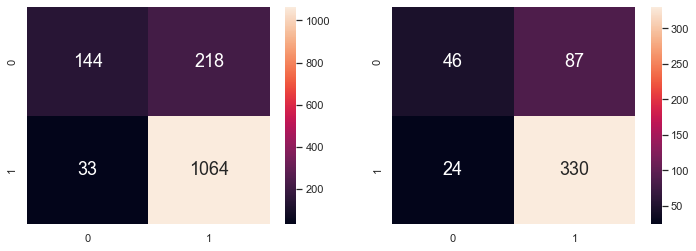

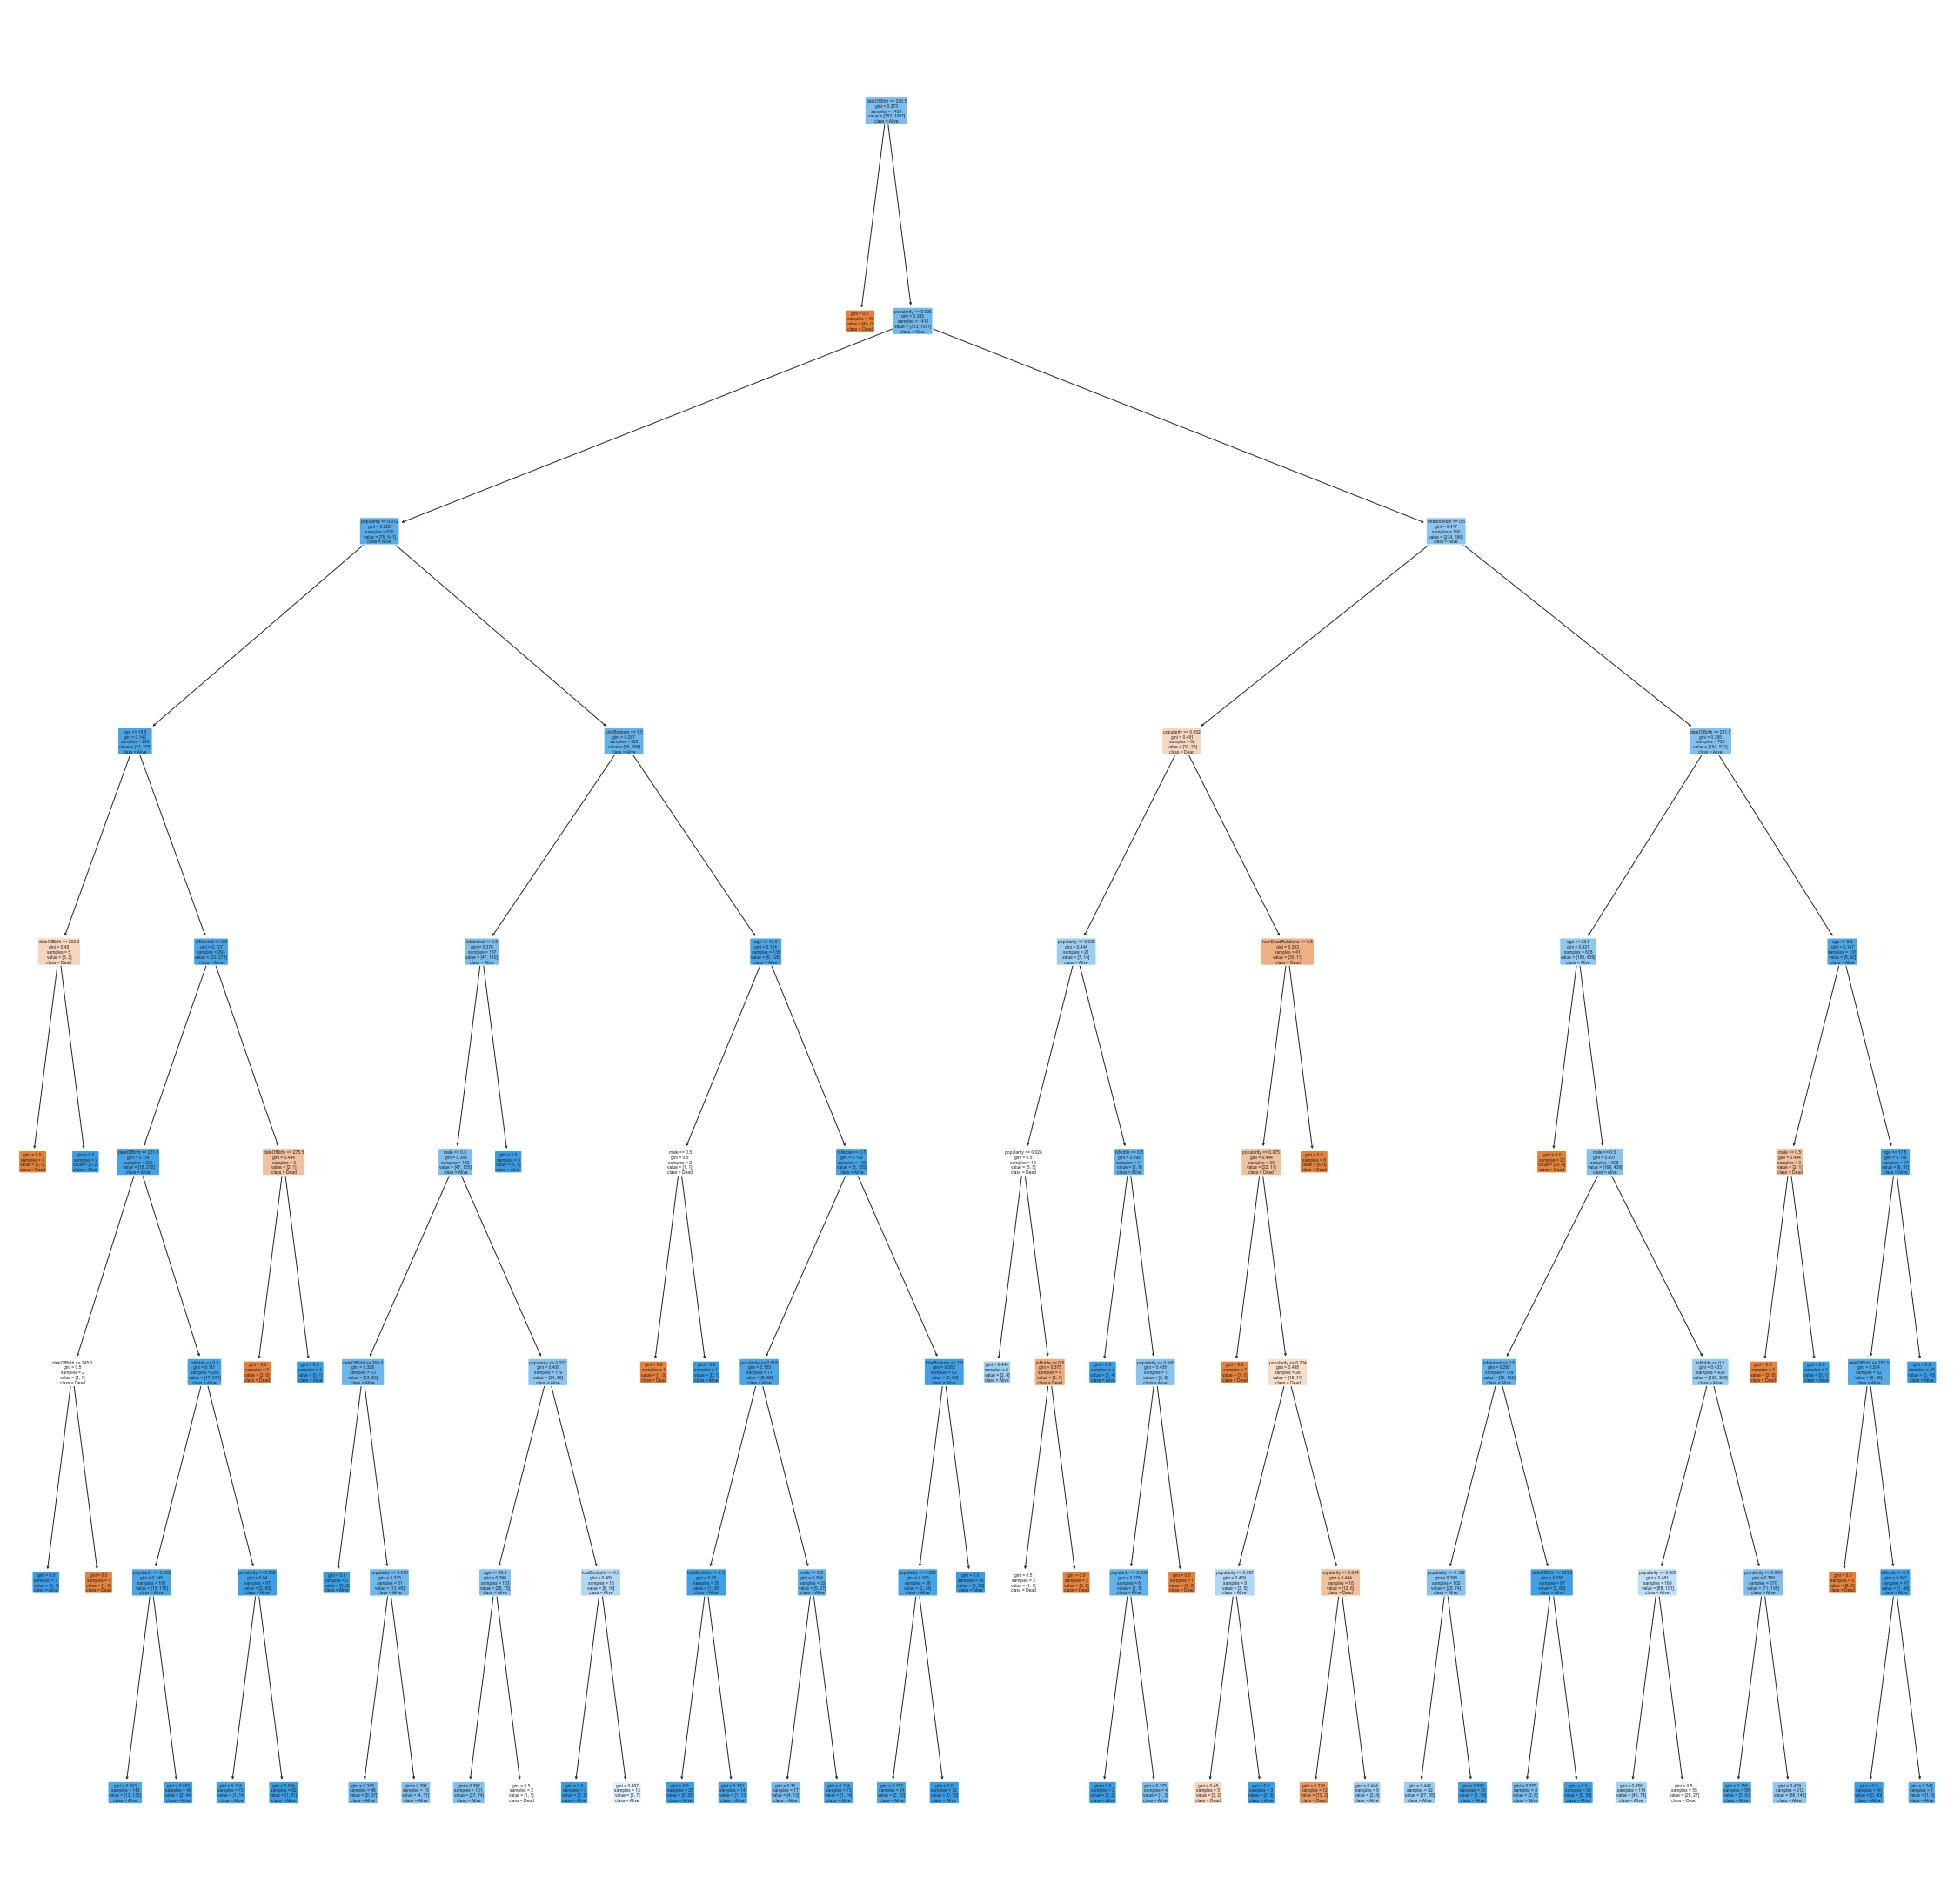

In [76]:
from sklearn.tree import plot_tree

def classification(X,y):
# Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=500)
    
    # Check the sample sizes
    print("Train Set :", y_train.shape, X_train.shape)
    print("Test Set  :", y_test.shape, X_test.shape)


    dectree = DecisionTreeClassifier(max_depth = 8) 
    dectree.fit(X_train, y_train)   
    
    # Predict Response corresponding to Predictors
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    cm_train=confusion_matrix(y_train, y_train_pred)
    cm_test=confusion_matrix(y_test, y_test_pred)

    # Check the Goodness of Fit (on Train Data)
    print("TRAIN Dataset")
    print("Classification Accuracy: \t", dectree.score(X_train, y_train))
    print("AUC score: \t", roc_auc_score(y_train, y_train_pred))
    print("F1-score: \t", f1_score(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("TEST Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("AUC score\t:", roc_auc_score(y_test, y_test_pred))
    print("F1-score: \t", f1_score(y_test, y_test_pred))
    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap((cm_train),
        annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap((cm_test), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    f = plt.figure(figsize=(40,40))
    plot_tree(dectree, filled=True, rounded=True, 
              feature_names=X_train.columns, 
              class_names=["Dead","Alive"])
    
    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test=classification(pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']]),pd.DataFrame(char_data_clean["isAlive"]))

### Cost Complexity Pruning (CCP)
CCP is used to decrease overfitting by reducing the size of the Decision Tree, hence reducing complexity and improving predictive accuracy. 

In [60]:
dectree = DecisionTreeClassifier(max_depth = 8) 

path = dectree.cost_complexity_pruning_path(X_train, y_train)
alphas=path['ccp_alphas']

alphas

array([0.00000000e+00, 5.15759770e-05, 6.27656556e-05, 7.00140765e-05,
       7.81966122e-05, 1.02074423e-04, 1.14233493e-04, 1.20564936e-04,
       1.45539817e-04, 1.66662847e-04, 2.81835634e-04, 2.95785281e-04,
       3.42700480e-04, 4.23147498e-04, 4.44864171e-04, 5.50397740e-04,
       5.71167466e-04, 6.03562039e-04, 6.03977387e-04, 6.07423470e-04,
       7.26940412e-04, 9.13867946e-04, 9.13867946e-04, 9.25291295e-04,
       1.00833026e-03, 1.16698193e-03, 1.27304514e-03, 1.48785058e-03,
       1.64496230e-03, 1.71894365e-03, 1.90544199e-03, 2.61119942e-03,
       2.82513569e-03, 2.96625190e-03, 3.02112088e-03, 3.27761246e-03,
       9.31440791e-03, 1.35654025e-02, 3.92924975e-02])

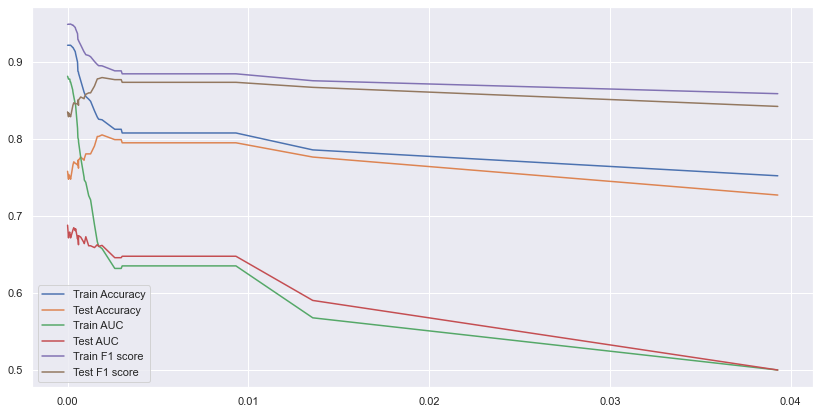

In [77]:
accuracy_train,accuracy_test,auc_train, auc_test, f1_train, f1_test=[],[],[],[],[],[]


for i in alphas :
        dectree=DecisionTreeClassifier(ccp_alpha=i)
        
        dectree.fit(X_train, y_train)
        y_train_pred=dectree.predict(X_train)
        y_test_pred=dectree.predict(X_test)
        
        accuracy_train.append(accuracy_score(y_train,y_train_pred))
        accuracy_test.append(accuracy_score(y_test,y_test_pred))
        auc_train.append(roc_auc_score(y_train,y_train_pred))
        auc_test.append(roc_auc_score(y_test,y_test_pred))
        f1_train.append(f1_score(y_train,y_train_pred))
        f1_test.append(f1_score(y_test,y_test_pred))
    

sb.set()
plt.figure(figsize= (14,7))
sb.lineplot(y=accuracy_train,x=alphas, label="Train Accuracy")
sb.lineplot(y=accuracy_test,x=alphas,label="Test Accuracy")
sb.lineplot(y=auc_train,x=alphas, label="Train AUC")
sb.lineplot(y=auc_test,x=alphas,label="Test AUC")
sb.lineplot(y=f1_train,x=alphas, label="Train F1 score")
sb.lineplot(y=f1_test,x=alphas,label="Test F1 score")
plt.xticks(ticks=np.arange(0.00, 0.05, 0.01))
plt.show()

In [78]:
#reduce overfitting
print("Results of Cost Complexity Pruning(CCP)")
print("TEST set")
print("maximum accuracy:", max(accuracy_test))
print("maximum AUC:", max(auc_test))
print("maximum F1 score:", max(f1_test))


Results of Cost Complexity Pruning(CCP)
TEST set
maximum accuracy: 0.8049281314168378
maximum AUC: 0.6878212480353426
maximum F1 score: 0.8792884371029225


### Feature selection on Random Forest
Used to identify more important variables through Gini Impurity (the more a variable decreases the impurity, the more important it is)

Increases interpretability and predictive accuracy

Index(['dateOfBirth', 'age', 'popularity'], dtype='object')
Train Set : (1459, 1) (1459, 3)
Test Set  : (487, 1) (487, 3)
TRAIN Dataset
Classification Accuracy: 	 0.8224811514736121
AUC score: 	 0.6672517211682287
F1-score: 	 0.8920383493122134

TEST Dataset
Classification Accuracy 	: 0.8090349075975359
AUC score	: 0.6738456310267193
F1-score: 	 0.8809218950064022



(      dateOfBirth   age  popularity
 145         268.0  27.0    0.006689
 461         249.0  50.0    0.096990
 341         299.0   6.0    0.000000
 46          268.0  27.0    0.010033
 930         271.0  28.0    0.073579
 ...           ...   ...         ...
 1742        268.0  27.0    0.127090
 273         283.0  22.0    0.969900
 1857        268.0  27.0    0.083612
 951         268.0  27.0    0.013378
 858         268.0  27.0    0.010033
 
 [1459 rows x 3 columns],
       dateOfBirth   age  popularity
 1025        268.0  27.0    0.066890
 654         268.0  27.0    0.003344
 483         268.0  27.0    0.006689
 193         268.0  27.0    0.016722
 1220        268.0  27.0    0.023411
 ...           ...   ...         ...
 1734        268.0  27.0    0.030100
 1195        249.0  56.0    0.274247
 17          268.0  27.0    0.020067
 246         295.0  10.0    0.026756
 1504        237.0  68.0    0.230769
 
 [487 rows x 3 columns],
       isAlive
 145         1
 461         0
 341        

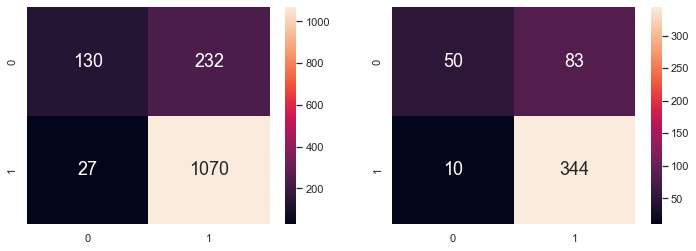

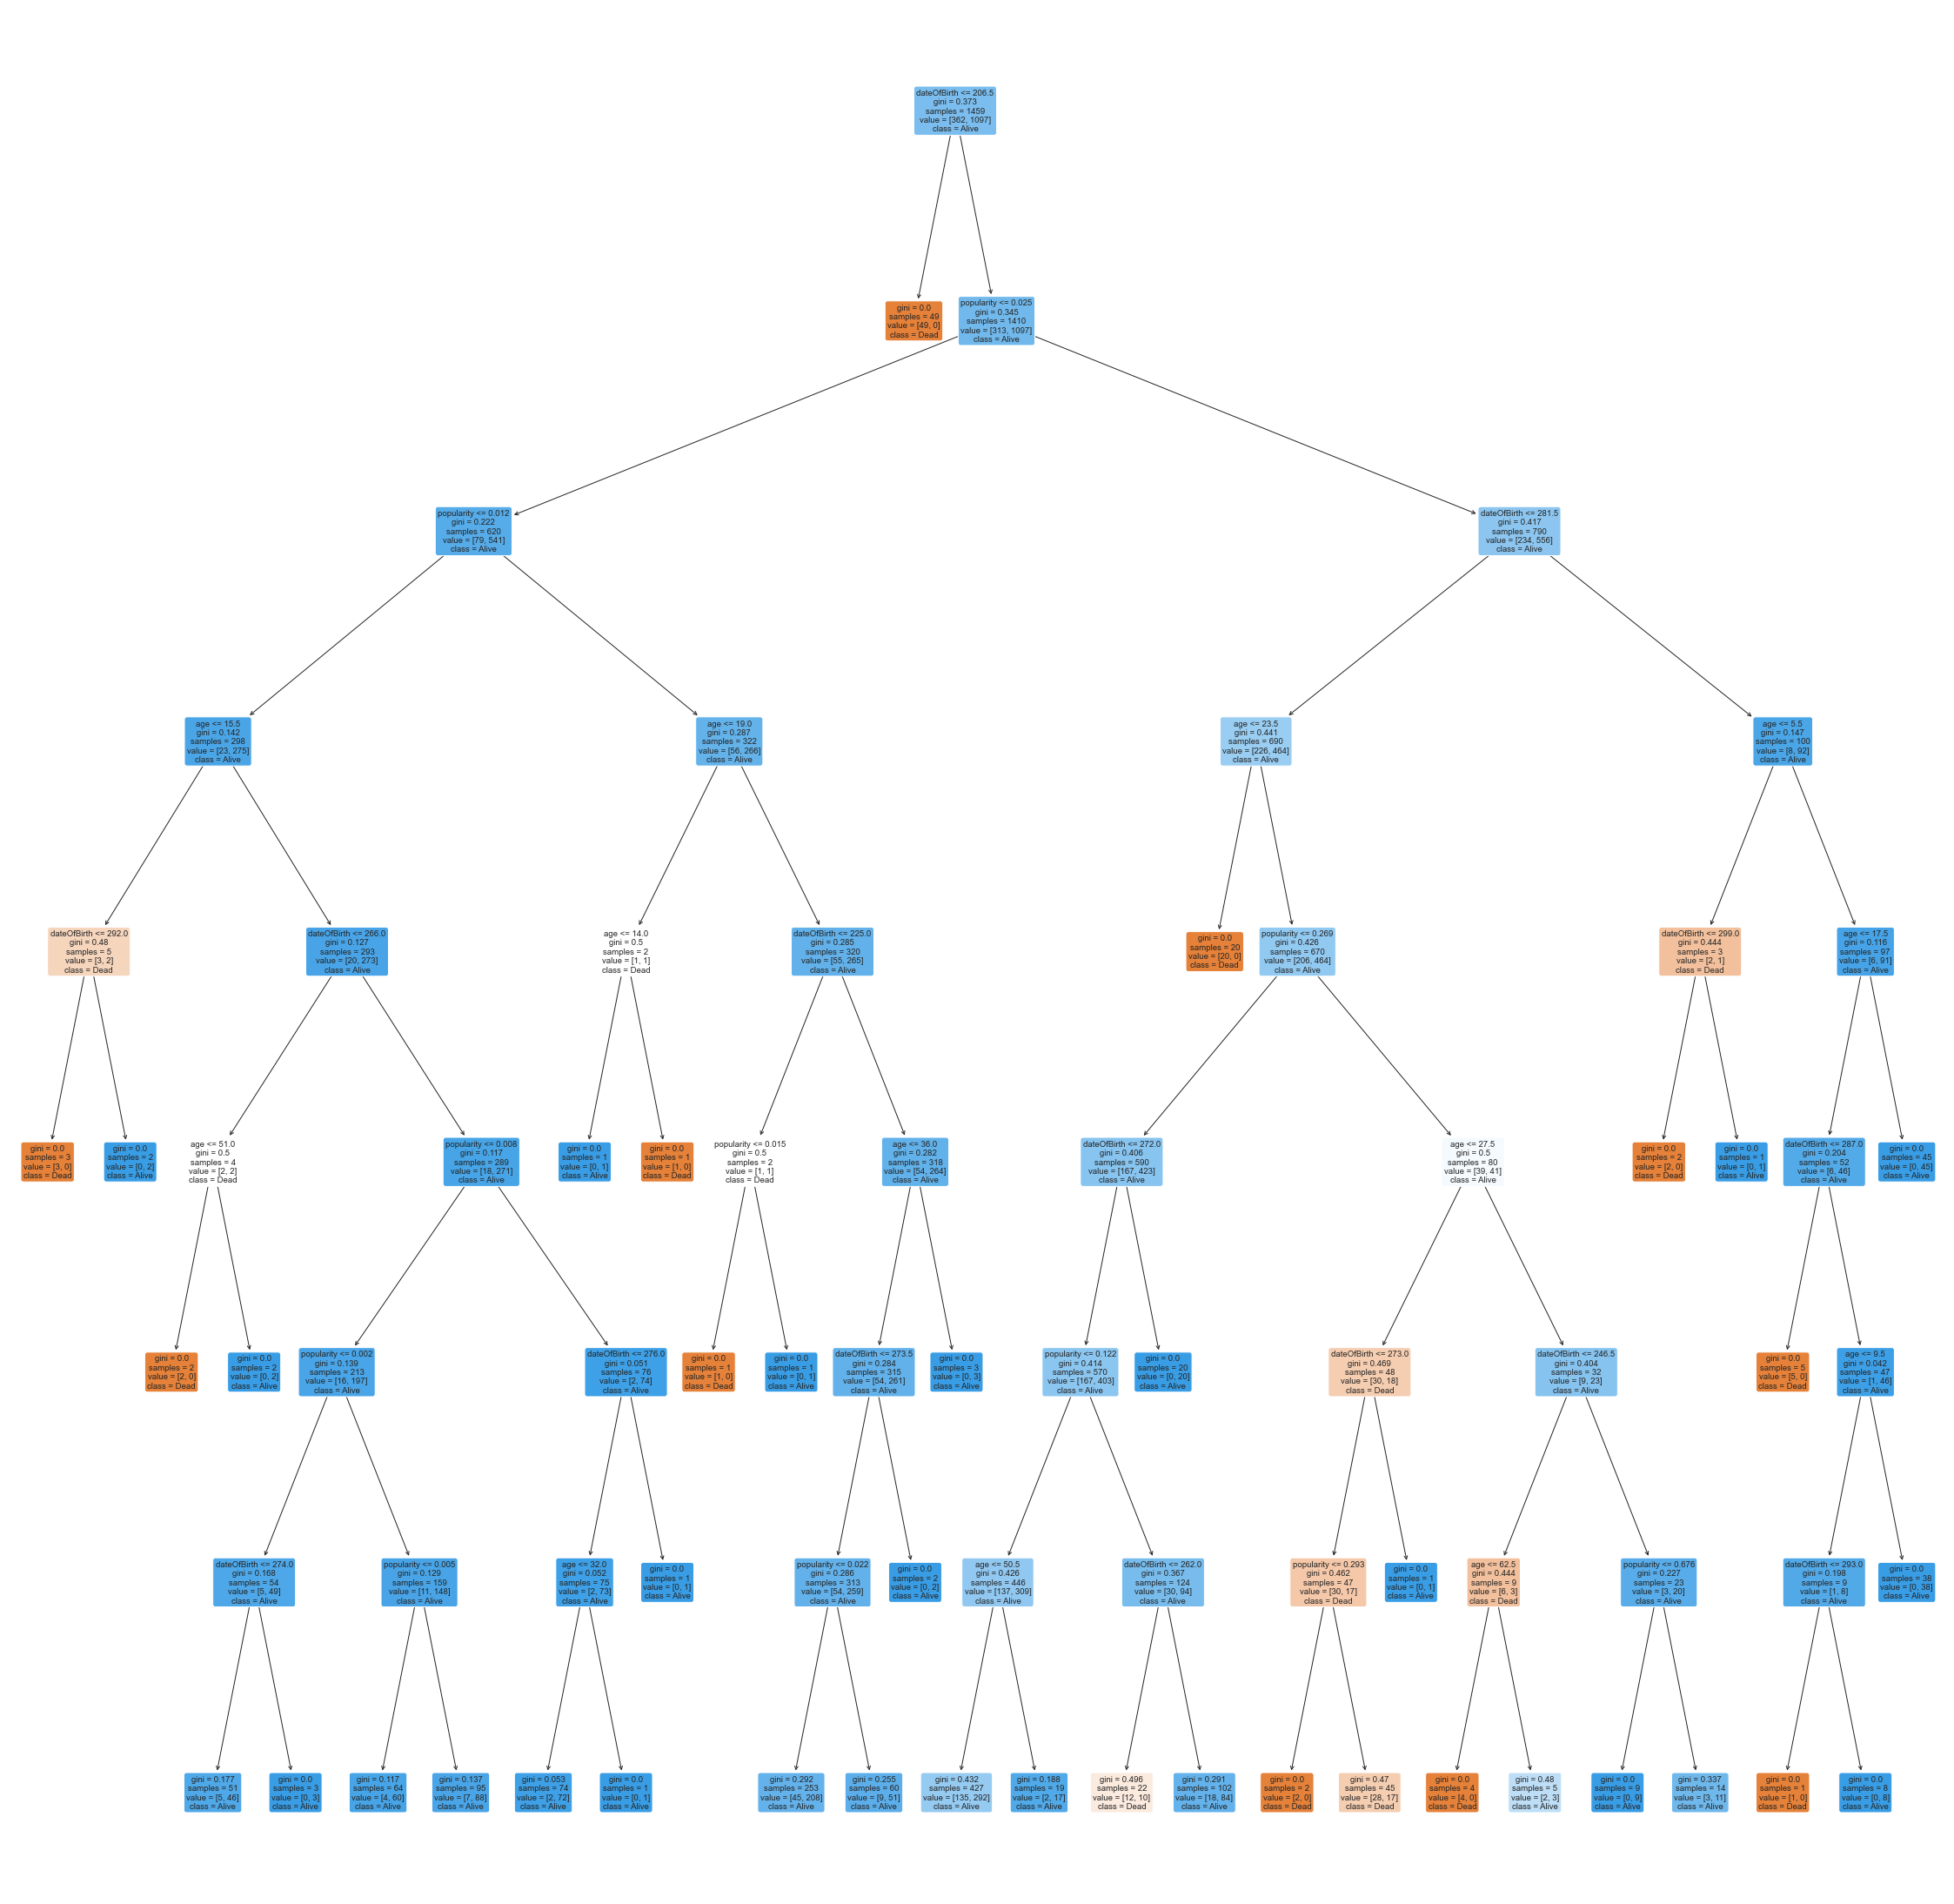

In [79]:
forest_classifier = SelectFromModel(RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                     ))
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=500)

forest_classifier.fit(X_train, y_train.values.ravel())
forest_classifier.get_support()
selected_feat= X_train.columns[(forest_classifier1.get_support())]
print(selected_feat)

#with higher efficiency; better than using all variables to predict 
classification(pd.DataFrame(char_data_clean[selected_feat]),pd.DataFrame(char_data_clean['isAlive']))

### XGBoost
XGBoost uses a gradient boosting framework to improve model performance through optimized hyper-parameter tuning.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

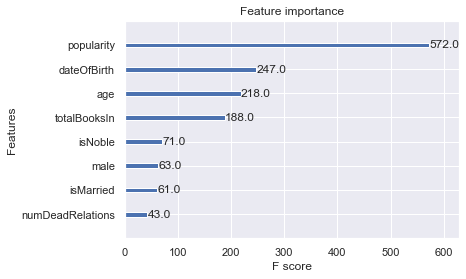

In [66]:
# Xgboost 
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=500)

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_test_pred = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, y_test_preds)

xgb.plot_importance(xgb_cl)

### XGBoost with GridSearchCV
GridSearch is an optimizatoin algorithm to find the best hyperparameters.
As the time complexity of GridSearchCV is very high, we have used HalvingGridSearchCV instead.

In [80]:
from sklearn.model_selection import GridSearchCV
#To find hyperparameters for highest accuracy
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
gridSearch_xgb = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='accuracy', 
                   verbose=1)
gridSearch_xgb.fit(X, y)
print("Best parameters:", gridSearch_xgb.best_params_)
print("Highest accuracy: ", gridSearch_xgb.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Highest accuracy:  0.7985344393501709


In [81]:
#To find hyperparameters for best AUC
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
clf = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring="roc_auc", 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Highest AUC: ", clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Highest AUC:  0.7735135861462415


In [82]:
#To find hyperparameters for best F1 score
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
clf = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring="f1", 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Highest F1 score: ", clf.best_score_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Highest F1 score:  0.8697561680043124


In [79]:
from lightgbm import LGBMClassifier
# define dataset
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 500)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 70,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': 1
             }

model_lgb = lgb.train(parameters,
                            train_data,
                            valid_sets=test_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 1097, number of negative: 362
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751885 -> initscore=1.108690
[LightGBM] [Info] Start training from score 1.108690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.735185
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.7344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.74538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	v

C:\Users\denis\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [80]:

y_train_pred = model_lgb.predict(X_train)
y_test_pred = model_lgb.predict(X_test)


print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))


AUC Train: 0.7789
AUC Test: 0.7875
